# 3. Улучшение модели (transfer learning)
- настройка классификатора под три класса
- разделение выборки train / valid
- настройка и использование предобученной ResNet50
- балансировка классов
- optuna: поиск гиперпараметров (warm-up stage1->stage2)
- подход с заморозкой слоев и fine-tuning с лучшими гиперпараметрами
- инференс модели и расчет **Accuracy** и **F1-score** (валидационная выборка)
- сохранение отчета метрик модели в csv
- применение **Grad-CAM** для визуализации областей внимания
- сравнение результатов с baseline

## 3.1. Обоснование выбора подхода Transfer Learning

После построения и анализа базовой модели на архитектуре **ResNet18**, следующий шаг - улучшить качество классификации за счет применения **transfer learning** (*обучения с переносом знаний*).

---

### Основные идеи и причины выбора подхода

1. **Повышение точности за счет более глубокой архитектуры.**  
   Для дальнейших экспериментов выбрана **ResNet50**, которая содержит 50 слоев и способна извлекать более сложные визуальные признаки (мелкие затемнения, текстурные паттерны, особенности симметрии легких).  
   При этом архитектура сохраняет остаточные связи (*residual connections*), что предотвращает затухание градиентов и делает обучение устойчивым даже на небольшой медицинской выборке.

2. **Использование предобученных весов (ImageNet).**  
   Модель инициализируется весами, обученными на крупном датасете **ImageNet**, что позволяет:
   - ускорить сходимость обучения,  
   - повысить обобщающую способность,  
   - адаптировать сеть под особенности рентгеновских изображений при малом количестве данных.

3. **Заморозка и дообучение слоев (Fine-Tuning).**  
   На первом этапе обучения **замораживаются сверточные блоки** (feature extractor), и обучается только финальный классификатор.  
   После стабилизации метрик выполняется **разморозка верхних слоев** для тонкой настройки под специфику медицинских снимков.  
   Такой двухэтапный подход позволяет сохранить базовые визуальные паттерны и оптимально адаптировать их под задачу диагностики пневмонии.

4. **Аугментации данных для повышения устойчивости модели.**  
   Для борьбы с переобучением и увеличения разнообразия тренировочных данных применяются пространственные и фотометрические преобразования:
   - `RandomHorizontalFlip`,  
   - `RandomRotation`,  
   - `ColorJitter`,  
   - `RandomResizedCrop`.  

   Эти операции моделируют реальные вариации снимков (контраст, положение пациента, освещение), повышая устойчивость модели к шуму и внешним артефактам.

5. **Оптимизация гиперпараметров.**  
   Выполняется подбор гиперпараметров (learning rate, batch size, scheduler - например, `OneCycleLR`), что позволяет добиться стабильной сходимости и лучшего баланса между точностью и скоростью обучения.

---

### 3.2. Ожидаемые результаты

- Повышение **F1-score** (особенно по классу *Lung Opacity*).  
- Улучшение способности модели к обобщению (generalization).  
- Снижение количества ошибок типов *false positive* и *false negative*.  
- Подготовка улучшенной модели для анализа карт активаций (Grad-CAM) на следующем этапе.

---

**Таким образом**, использование подхода *transfer learning* с архитектурой **ResNet50** позволяет углубить представления модели о визуальных паттернах легких и повысить точность диагностики пневмонии при сохранении вычислительной эффективности.

Примечание: Данный ноутбук будет использоваться как локально, так и в Kaggle для обучения модели для лучшей воспроизводимости.

# Контроль запуска - первый запуск или нет

In [1]:
IS_FIRST_RUN = False # Если не хотите заново дообучать модели и вы скачали transfer_resnet50_stage1_optuna.pth и transfer_resnet50_optuna.pth, можно оставить False.
IS_OPTUNA_RUN = False # ВНИМАНИЕ! Гиперпараметры optuna, на моей конфигурации выполняется около 48 часов!

### Библиотеки

In [2]:
import sys
from pathlib import Path # удобная работа с путями (совместима с Windows/Linux)
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
# ----------------------------техническая строка-------------------------------
import os, random                  # работа с путями и генераторами случайных чисел
import numpy as np                 # численные операции и работа с массивами
import torch                       # основной фреймворк PyTorch для нейронных сетей
import pandas as pd                # работа с табличными данными (DataFrame)
import matplotlib.pyplot as plt    # визуализация графиков и изображений
import torch.nn as nn              # модуль для построения нейросетей (Linear, Conv, и т.д.)
import json
import optuna
from pathlib import Path           # удобная работа с путями (совместима с Windows/Linux)
from PIL import Image              # загрузка и обработка изображений (PNG, JPEG)
from optuna.pruners import MedianPruner
from pytorch_grad_cam import GradCAM # библиотека для использования GRAD-CAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms  # стандартные трансформации изображений (resize, flip, tensor)
from torch.utils.data import DataLoader  # классы для создания датасетов и загрузчиков данных
from sklearn.model_selection import train_test_split  # разбиение данных на train/val
from sklearn.metrics import (                         # расчет метрик качества
    classification_report,                            # табличный отчет по precision/recall/F1
    confusion_matrix,                                 # матрица ошибок
    ConfusionMatrixDisplay                            # визуализация матрицы ошибок
)

#src
from src.models import (
    RSNADataset,
    compute_class_weights,
    ResNet50Transfer,
    predictions_on_validation,
    model_fit
)
from src.optuna import (
    dataloaders_for_optuna,
    resnet50_run_epoch_optuna
)
from src.metrics import (
    plot_metric_bars, 
    plot_metric_classes
)
from src.reports import save_model_report
from src.grad_cam import show_gradcam_png_grid

In [3]:
# Проверяем параметры графической карты
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available!')
    print('Device name:', torch.cuda.get_device_name(0))
    print(f'Cuda version: {torch.version.cuda}')
else:
    print('CUDA is not available.')

CUDA is available!
Device name: NVIDIA GeForce RTX 3060 Laptop GPU
Cuda version: 12.4


In [4]:
# Воспроизводимость для KAGGLE / локально
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False; torch.backends.cudnn.benchmark = True

# среда
ON_KAGGLE = Path('/kaggle/input').exists()

if ON_KAGGLE:
    BASE_DIR = Path('/kaggle/working')
    INPUT_DIR = Path('/kaggle/input/rsna-pneumonia-processed-png-meta')  # имя датасета на Kaggle
    PROC_DIR = INPUT_DIR
else:
    BASE_DIR = Path.cwd().parent
    PROC_DIR = BASE_DIR / 'data' / 'processed'

IMG_DIR = PROC_DIR / 'train_png'
META_DIR = PROC_DIR / 'meta_info_encoded.csv'

MODELS_DIR = BASE_DIR / 'models'; MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_FIG = BASE_DIR / 'reports' / 'figures'; REPORTS_FIG.mkdir(parents=True, exist_ok=True)
REPORTS_DIR = BASE_DIR / 'reports'

print('ON_KAGGLE:', ON_KAGGLE)
print('IMG_DIR:', IMG_DIR)
print('META_DIR:', META_DIR)

ON_KAGGLE: False
IMG_DIR: c:\Users\alexf\Desktop\rsna_pneumonia_project\data\processed\train_png
META_DIR: c:\Users\alexf\Desktop\rsna_pneumonia_project\data\processed\meta_info_encoded.csv


### Настройка классификатора под три класса

In [5]:
meta_info_encoded = pd.read_csv(META_DIR)

# трехклассовая цель создаем новый признак (закодированный)
CLASS_MAP = {'Normal':0, 'Lung Opacity':1, 'No Lung Opacity / Not Normal':2}
meta_info_encoded['class_id'] = meta_info_encoded['class'].map(CLASS_MAP)

meta_info_encoded.head(10)

,patientId,class,age,rows,cols,sex_F,sex_M,vp_AP,vp_PA,spacing_x,spacing_y,class_id
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,51.0,1024,1024,True,False,False,True,0.143000,0.143000,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,48.0,1024,1024,True,False,False,True,0.194311,0.194311,2
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,19.0,1024,1024,False,True,True,False,0.168000,0.168000,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,28.0,1024,1024,False,True,False,True,0.143000,0.143000,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,32.0,1024,1024,True,False,True,False,0.139000,0.139000,1
5,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,54.0,1024,1024,False,True,True,False,0.139000,0.139000,2
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,78.0,1024,1024,False,True,False,True,0.143000,0.143000,2
7,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,75.0,1024,1024,False,True,False,True,0.143000,0.143000,1
8,008c19e8-a820-403a-930a-bc74a4053664,No Lung Opacity / Not Normal,59.0,1024,1024,True,False,False,True,0.194311,0.194311,2
9,009482dc-3db5-48d4-8580-5c89c4f01334,Normal,63.0,1024,1024,False,True,False,True,0.143000,0.143000,0


### Разделение выборки train / valid

In [6]:
train, valid = train_test_split(
    meta_info_encoded['patientId'],
    test_size=0.2, # 80/20
    random_state=SEED,
    stratify=meta_info_encoded['class_id'] # стратифицируем выборку (важно)
)

# Размеры выборок
df_train = meta_info_encoded[meta_info_encoded.patientId.isin(train)].reset_index(drop=True)
df_val = meta_info_encoded[meta_info_encoded.patientId.isin(valid)].reset_index(drop=True)

# Проверка стратифицированного сплита
print(f'Размеры выборки: \n Train: {len(df_train)} \n Valid: {len(df_val)}\n')
print(f'Выборка до разделения: \n{meta_info_encoded['class'].value_counts(normalize=True)}\n')
print(f'Выборка Train: \n{df_train['class'].value_counts(normalize=True)}\n')
print(f'Выборка Valid: \n{df_val['class'].value_counts(normalize=True)}')

Размеры выборки: 
 Train: 21347 
 Valid: 5337

Выборка до разделения: 
class
No Lung Opacity / Not Normal    0.443000
Normal                          0.331697
Lung Opacity                    0.225304
Name: proportion, dtype: float64

Выборка Train: 
class
No Lung Opacity / Not Normal    0.443013
Normal                          0.331709
Lung Opacity                    0.225278
Name: proportion, dtype: float64

Выборка Valid: 
class
No Lung Opacity / Not Normal    0.442945
Normal                          0.331647
Lung Opacity                    0.225408
Name: proportion, dtype: float64


Мы так же как и в baseline получили идентичные размеры выборок.

### Настройка и использование предобученной ResNet50

### Балансировка классов (идентична как и в baseline)

In [7]:
WEIGHTS = compute_class_weights(df_train, num_classes=3, device=device)

Class distribution (train): Counter({2: 9457, 0: 7081, 1: 4809})
Class weights: [0.31044284 0.45711073 0.2324464 ]


### Optuna: поиск гиперпараметров (warm-up Stage 1 -> fine-tuning Stage 2)

Для подбора гиперпараметров модели ResNet50 применяется двухэтапное обучение одной и той же модели - классический прием transfer learning (пошаговое «прогревание» сети):

**Этап 1 - Warm-up (прогрев):**

Все сверточные блоки layer3 и layer4 заморожены (их веса не обновляются).

Обучаются только веса классификатора (fc-слоя) в течение 2 эпох.

Такой 'прогрев' позволяет:
- плавно адаптировать верхние слои модели под новую медицинскую выборку;
- избежать скачков градиента и 'разрушения' уже выученных признаков из ImageNet;
- снизить риск переобучения, если размер датасета небольшой.

**Этап 2 - Fine-tuning (тонкая настройка):**

Размораживаются слои layer4 (или layer3 + layer4, в зависимости от trial) и fc-слой.

Модель обучается еще 2 эпохи с меньшей скоростью обучения, чтобы донастроить высокоуровневые признаки под нашу задачу.

Лучшие веса сохраняются по метрике F1 (validation).

Таким образом, каждый trial Optuna проходит полный цикл warm-up -> fine-tuning на одной и той же сети.

Такой подход делает обучение более стабильным, а процесс подбора гиперпараметров - надежным и воспроизводимым даже на небольших наборах медицинских снимков.

In [8]:
VERBOSE_HPO=True # <--- выводить лог между триалами
if IS_OPTUNA_RUN:
    def objective(trial):
        '''
        Целевая функция для Optuna - подбор гиперпараметров модели ResNet50 (transfer learning).
        Включает два этапа обучения: 
        1) обучение только полносвязного слоя (fc)
        2) fine-tuning (размораживание последних блоков ResNet50)
        '''

        # 1. Определяем гиперпараметры, которые Optuna будет подбирать
        img_size     = trial.suggest_categorical('img_size', [384, 448, 512])     # размер входных изображений
        batch_size   = trial.suggest_categorical('batch_size', [8, 12, 16])       # размер батча
        lr_fc        = trial.suggest_float('lr_fc', 0.0002, 0.003, log=True)      # скорость обучения для классификатора
        lr_ft        = trial.suggest_float('lr_ft', 0.00005, 0.002, log=True)     # скорость обучения для fine-tuning
        weight_decay = trial.suggest_float('weight_decay', 0.000001, 0.0005, log=True)  # L2-регуляризация
        unfreeze     = trial.suggest_categorical('unfreeze', ['layer4', 'layer3+layer4'])  # глубина разморозки
        scheduler_on = trial.suggest_categorical('scheduler', ['none', 'cosine'])           # вариант шедулера

        # 2. Создаем даталоадеры (только для текущего trial'а)
        dl_tr_local, dl_va_local = dataloaders_for_optuna(
            img_size, batch_size, max(16, batch_size),
            df_train, df_val, IMG_DIR
        )

        # 3. Инициализация модели и основных компонентов
        model_local = ResNet50Transfer(n_classes=3, freeze_backbone=True).to(device)
        criterion_local = nn.CrossEntropyLoss(weight=WEIGHTS)     # функция потерь с учетом весов классов
        amp_flag = (device.type == 'cuda')                        # используем AMP, если есть GPU
        scaler = torch.amp.GradScaler('cuda', enabled=amp_flag)   # масштабирование градиентов для стабильности

        def _cur_lr(opt):
                    try:
                        return float(opt.param_groups[0]['lr'])
                    except Exception:
                        return float('nan')
                    
        # 4. ==========> Этап 1: обучение только fc-слоя (2 эпохи) <==========
        for name, p in model_local.named_parameters():
            p.requires_grad = ('fc' in name)

        opt_fc = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model_local.parameters()),
            lr=lr_fc, weight_decay=weight_decay
        )

        # Шедулер (если выбран cosine)
        sched_fc = (
            torch.optim.lr_scheduler.CosineAnnealingLR(opt_fc, T_max=2, eta_min=lr_fc * 0.1)
            if scheduler_on == 'cosine' else None
        )

        best_va_f1 = 0.0  # для отслеживания лучшего результата

        for e in range(2):
            # обучение
            resnet50_run_epoch_optuna(
                model_local, 
                dl_tr_local, 
                criterion_local, 
                scaler, 
                device, 
                opt_fc, 
                amp_flag)
            # оценка на валидации
            _, va_f1 = resnet50_run_epoch_optuna(
                model_local, 
                dl_va_local, 
                criterion_local, 
                scaler, 
                device, 
                None, 
                amp_flag)

            # обновляем лучший F1
            best_va_f1 = max(best_va_f1, va_f1)

            # шаг шедулера
            if sched_fc:
                sched_fc.step()

            # ---> ПРОГРЕСС-ЛОГ ДЛЯ STAGE 1 <---
            if VERBOSE_HPO:
                print(
                    f'[Trial {trial.number}] [Stage 1 {e+1}/2] val F1={va_f1:.4f} (best={best_va_f1:.4f}) | '
                    f'lr={_cur_lr(opt_fc):.6f} | sz={img_size} bs={batch_size} '
                    f'| planned_unfreeze={unfreeze} | sched={scheduler_on}',
                    flush=True)

            # отчет для Optuna (для pruning)
            trial.report(best_va_f1, step=e)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        # 5. ==========> Этап 2: разморозка + fine-tuning (еще 2 эпохи) <==========
        for _, p in model_local.named_parameters():
            p.requires_grad = False

        for name, p in model_local.named_parameters():
            if ('fc' in name) or \
            (unfreeze == 'layer4' and 'layer4' in name) or \
            (unfreeze == 'layer3+layer4' and ('layer3' in name or 'layer4' in name)):
                p.requires_grad = True

        opt_ft = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model_local.parameters()),
            lr=lr_ft, weight_decay=weight_decay
        )

        sched_ft = (
            torch.optim.lr_scheduler.CosineAnnealingLR(opt_ft, T_max=2, eta_min=lr_ft * 0.1)
            if scheduler_on == 'cosine' else None
        )

        for e in range(2):
            # обучение fine-tuned слоев
            resnet50_run_epoch_optuna(
                model_local, 
                dl_tr_local, 
                criterion_local, 
                scaler, 
                device, 
                opt_ft, 
                amp_flag)
            # оценка
            _, va_f1 = resnet50_run_epoch_optuna(
                model_local, 
                dl_va_local, 
                criterion_local, 
                scaler, 
                device, 
                None, 
                amp_flag)

            best_va_f1 = max(best_va_f1, va_f1)

            if sched_ft:
                sched_ft.step()

            # ---> ПРОГРЕСС-ЛОГ ДЛЯ STAGE 2 <---
            if VERBOSE_HPO:
                print(
                    f'[Trial {trial.number}] [Stage 2 {e+1}/2] val F1={va_f1:.4f} (best={best_va_f1:.4f}) | '
                    f'lr={_cur_lr(opt_fc):.6f} | sz={img_size} bs={batch_size} '
                    f'| unfreeze={unfreeze} | sched={scheduler_on}',
                    flush=True)

            trial.report(best_va_f1, step=2 + e)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        # 6. Очистка памяти между trial'ами (важно при долгих запусках)
        torch.cuda.empty_cache()

        return best_va_f1

Запуск optuna

In [9]:
if IS_OPTUNA_RUN:
    sampler = optuna.samplers.TPESampler(seed=SEED) # TPE-сэмплер; фиксируем seed для воспроизводимости
    pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=1) # Прунер по медиане: раннее отсечение слабых трейалов
    study = optuna.create_study(
        direction='maximize',  # Максимизируем целевую метрику (например, val F1)
        sampler=sampler, # Стратегия выбора гиперпараметров (TPE)
        pruner=pruner # Раннее завершение неудачных экспериментов
    )

    n_trials = 100 # Серьезный прогон на сутки!
    
    study.optimize(
        objective,
        n_trials=n_trials,
        show_progress_bar=True)

    print('Best trial:', study.best_trial.number)
    print('Best value (val F1):', study.best_value)
    print('Best params:', study.best_trial.params)

Сохранение оптимальных гиперпараметров optuna в json

In [10]:
if IS_OPTUNA_RUN:
    # Лучшие параметры
    best = study.best_trial.params
    best_value = float(study.best_value)

    # Готовим путь
    REPORTS_DIR.mkdir(parents=True, exist_ok=True)
    best_json = REPORTS_DIR / 'best_optuna_params.json'
    best_txt = REPORTS_DIR / 'best_optuna_config.txt'

    # Читаемый 'ярлык' конфига для логов/метрик
    def fmt(v):
        if isinstance(v, float):
            # компактная запись LR/WD
            return f'{v:.1e}' if v < 0.0002 else f'{v:.4f}'
        return str(v)

    config_name = (
        f'resnet50_tl_optuna'
        f'_sz{best.get('img_size')}'
        f'_bs{best.get('batch_size')}'
        f'_lrfc{fmt(best.get('lr_fc'))}'
        f'_lrft{fmt(best.get('lr_ft'))}'
        f'_wd{fmt(best.get('weight_decay'))}'
        f'_{best.get('unfreeze')}'
        f'_{best.get('scheduler')}'
    )

    # Сохранение best-параметров в JSON
    payload = {
        'best_value_val_f1': best_value,
        'best_params': best,
        'config_name': config_name,
        'seed': SEED,
    }
    with open(best_json, 'w', encoding='utf-8') as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

    # Короткий TXT
    with open(best_txt, 'w', encoding='utf-8') as f:
        f.write(f'{config_name}\nval_f1={best_value:.4f}\nparams={best}\n')

    print('Best params saved to:', best_json)
    print('Config tag:', config_name)

Загрузка json с лучшими параметрами

In [11]:
best_json = REPORTS_DIR / 'best_optuna_params.json'
with open(best_json, 'r', encoding='utf-8') as f:
    best_payload = json.load(f)

best = best_payload['best_params']
config_name = best_payload.get('config_name', 'resnet50_tl_optuna')

print('Loaded best params:', best)
print('Config tag:', config_name)

if IS_FIRST_RUN:
    # Переопределяем глобальные tfm и DataLoader под лучшие гиперпараметры
    IMG_SIZE = int(best['img_size'])

    tfm_train = transforms.Compose([
        transforms.Grayscale(1),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(7),
        transforms.ColorJitter(brightness=0.10, contrast=0.10),
        transforms.ToTensor()
    ])
    tfm_val = transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])

    ds_train = RSNADataset(df_train, IMG_DIR, tfm_train)
    ds_val = RSNADataset(df_val, IMG_DIR, tfm_val)

    dl_tr = DataLoader(ds_train, batch_size=int(best['batch_size']), shuffle=True,  num_workers=0, pin_memory=True)
    dl_va = DataLoader(ds_val,   batch_size=max(16, int(best['batch_size'])), shuffle=False, num_workers=0, pin_memory=True)

    print(f'Размеры датасетов: \nDataLoaderTrain: {len(dl_tr)} \nDataLoaderValid: {len(dl_va)}')

Loaded best params: {'img_size': 512, 'batch_size': 8, 'lr_fc': 0.0020292214181030924, 'lr_ft': 7.864557912273797e-05, 'weight_decay': 3.2161947858718945e-06, 'unfreeze': 'layer3+layer4', 'scheduler': 'none'}
Config tag: resnet50_tl_optuna_sz512_bs8_lrfc0.0020_lrft7.9e-05_wd3.2e-06_layer3+layer4_none


Дообучение модели с лучшими гиперпараметрами

In [12]:
EPOCS_STAGE_1 = 4
EPOCS_STAGE_2 = 6

# Шаг 1: обучаем только классификатор fc
model = ResNet50Transfer(n_classes=3, freeze_backbone=True).to(device)
criterion = nn.CrossEntropyLoss(weight=WEIGHTS)

if IS_FIRST_RUN:
    amp_enabled  = (device.type == 'cuda')
    scaler       = torch.amp.GradScaler('cuda', enabled=amp_enabled)

    opt_stage1 = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=float(best['lr_fc']),
        weight_decay=float(best['weight_decay'])
    )

    # Директория для сохранения модели с шага 1
    ckpt_stage1 = MODELS_DIR / 'transfer_resnet50_stage1_optuna.pth'

    best_f1_stage1 = model_fit(
        model_=model,
        scaler_=scaler,
        optimizer_=opt_stage1,
        criterion_=criterion,
        dl_tr_=dl_tr,
        dl_va_=dl_va,
        device_=device,
        epochs_=EPOCS_STAGE_1,
        ckpt_path_=ckpt_stage1, # <-- Вот здесь сохраняется, точно!
        amp_enabled_=amp_enabled
    )
    print(f'Лучший F1 (stage1): {best_f1_stage1:.4f}')

    # Шаг 2: fine-tuning
    # 2.1 Загружаем лучшие веса шаг 1 (иначе модель в RAM содержит веса последней эпохи, а не лучшие)
    print('Загружаем лучший чекпойнт Stage1 и настраиваем разморозку...')
    model.load_state_dict(torch.load(ckpt_stage1, map_location=device))

    # 2.2 Сначала всем выключаем градиенты, затем размораживаем ровно то, что выбрала Optuna
    for _, p in model.net.named_parameters():
        p.requires_grad = False

    if best.get('unfreeze') == 'layer3+layer4':
        model.unfreeze_layer3_4()
    else:
        model.unfreeze_layer4()

    # 2.3 Только теперь создаем оптимизатор под актуальный набор параметров тренировки
    opt_stage2 = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=float(best['lr_ft']),
        weight_decay=float(best['weight_decay'])
    )

    # Директория для сохранения модели с шага 2 (финального)
    ckpt_stage2 = MODELS_DIR / 'transfer_resnet50_optuna.pth'

    best_f1_stage2 = model_fit(
        model_=model,
        scaler_=scaler,
        optimizer_=opt_stage2,
        criterion_=criterion,
        dl_tr_=dl_tr,
        dl_va_=dl_va,
        device_=device,
        epochs_=EPOCS_STAGE_2,
        ckpt_path_=ckpt_stage2,
        amp_enabled_=amp_enabled
    )
    print(f'Лучший F1 (stage2): {best_f1_stage2:.4f}')

### Инференс модели и расчет **Accuracy** и **F1-score** (валидационная выборка)

In [13]:
# Опять загружаем лучшие параметры для использования модели (только валидация)
best_json = REPORTS_DIR / 'best_optuna_params.json'
best = best_payload['best_params']
with open(best_json, 'r', encoding='utf-8') as f:
    best_payload = json.load(f)

# Переопределяем глобальные tfm и DataLoader под лучшие гиперпараметры
IMG_SIZE = int(best['img_size'])

tfm_val = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

ds_val = RSNADataset(df_val, IMG_DIR, tfm_val)
dl_va = DataLoader(ds_val, batch_size=max(16, int(best['batch_size'])), shuffle=False, num_workers=0, pin_memory=True)

# Загрузка лучшего чекпойнта
best_path = MODELS_DIR / 'transfer_resnet50_optuna.pth'  # из этапа fine-tuning с лучшими гиперпараметрами
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()  # режим эксплуатации модели

# Предсказания на валидации (y_true, y_pred, y_prob)
y_true, y_pred, y_prob = predictions_on_validation(
    model_=model,
    device_=device,
    dl_va_=dl_va)

### Построение confusion matrix

                              precision    recall  f1-score   support

                      Normal     0.7636    0.9034    0.8276      1770
                Lung Opacity     0.6205    0.6850    0.6511      1203
No Lung Opacity / Not Normal     0.7436    0.6024    0.6656      2364

                    accuracy                         0.7208      5337
                   macro avg     0.7092    0.7302    0.7148      5337
                weighted avg     0.7225    0.7208    0.7161      5337



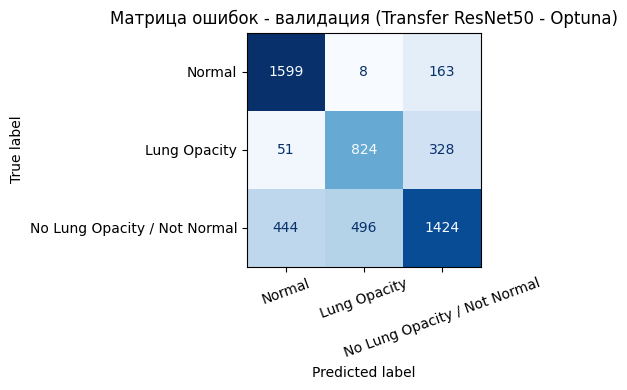

Матрица ошибок сохранена: c:\Users\alexf\Desktop\rsna_pneumonia_project\reports\figures\transfer_confusion_matrix.png


In [14]:
id_to_label = {0:'Normal', 1:'Lung Opacity', 2:'No Lung Opacity / Not Normal'}
target_names = [id_to_label[i] for i in sorted(id_to_label)]
fig_path = REPORTS_FIG / 'transfer_confusion_matrix.png'
REPORTS_FIG.mkdir(parents=True, exist_ok=True)

print(classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    digits=4))

conf_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(conf_matrix, display_labels=target_names).plot(
    ax=ax, 
    cmap='Blues',
    values_format='d',
    colorbar=False, 
    xticks_rotation=20
)

plt.title('Матрица ошибок - валидация (Transfer ResNet50 - Optuna)')
plt.tight_layout()
plt.savefig(fig_path, dpi=150)
plt.show()
print('Матрица ошибок сохранена:', fig_path)

Итоги после подбора гиперпараметров (Optuna 100 trial, Transfer Learning - ResNet50)

Модель показывает стабильный прирост по всем ключевым метрикам, особенно в части устойчивости между precision и recall.
Macro F1 вырос до 0.715, что подтверждает улучшение обобщающей способности сети.

**Класс Normal** уверенно детектируется:

F1 примерно 0.83, recall примерно 0.90 - модель надежно отличает здоровые снимки, практически не ошибаясь.
Ошибки в основном связаны с редкими артефактами или слабой контрастностью снимков.

**Класс Lung Opacity** остается наиболее сложным для классификации, однако наблюдается рост F1 до примерно 0.65 и recall до примерно 0.68 - сеть стала лучше улавливать паттерны патологии,
но часть случаев по-прежнему ошибочно классифицируется как No Lung Opacity / Not Normal. 

Это типичная ситуация для задач с перекрывающимися визуальными признаками патологий.

**Класс No Lung Opacity / Not Normal** демонстрирует более сбалансированное поведение:
- recall примерно 0.60 при precision примерно 0.74 - модель стала осторожнее,
- реже относит нормальные снимки к патологиям, что снижает количество ложных тревог.

### Cохранение отчета метрик модели в csv

In [15]:
# Сохраняем в основной CSV
REPORTS_DIR = REPORTS_FIG.parent  # 'reports'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
csv_path = REPORTS_DIR / 'transfer_optuna_metrics.csv'

num_epocs = EPOCS_STAGE_1 + EPOCS_STAGE_2

save_model_report(
    model_name='ResNet50Transfer',
    y_true=y_true,
    y_pred=y_pred,
    y_prob=y_prob,
    target_names=target_names,
    num_epocs=num_epocs,
    csv_path=csv_path
)

Сводные метрики сохранены в CSV: c:\Users\alexf\Desktop\rsna_pneumonia_project\reports\transfer_optuna_metrics.csv


### Использование Grad-CAM

In [16]:
# целевой слой (последний слой у ResNet50)
target_layer = model.net.layer4[-1].conv3
out_dir = REPORTS_FIG / 'gradcam_transfer'
out_dir.mkdir(parents=True, exist_ok=True)
n_show = min(6, len(ds_val))

with GradCAM(model=model, target_layers=[target_layer]) as cam:
    for i in range(n_show):
        img, y = ds_val[i]
        x = img.unsqueeze(0).to(device).requires_grad_(True)
        with torch.no_grad():
            pred_cls = int(model(x).argmax(1).item())

        grayscale_cam = cam(input_tensor=x, targets=[ClassifierOutputTarget(pred_cls)])[0]

        # Нормализация и RGB для оверлея
        base = img.squeeze().cpu().numpy()
        base = (base - base.min()) / (base.max() - base.min() + 1e-6)
        rgb_img = np.repeat(base[..., None], 3, axis=2)

        vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.65)

        pid = ds_val.df.iloc[i].patientId
        save_path = out_dir / f'{pid}_true{y}_pred{pred_cls}.png'
        Image.fromarray(vis).save(save_path)

    print('Снимки Grad-CAM (transfer) сохранены в:', out_dir)

Снимки Grad-CAM (transfer) сохранены в: c:\Users\alexf\Desktop\rsna_pneumonia_project\reports\figures\gradcam_transfer


### Выводим результаты

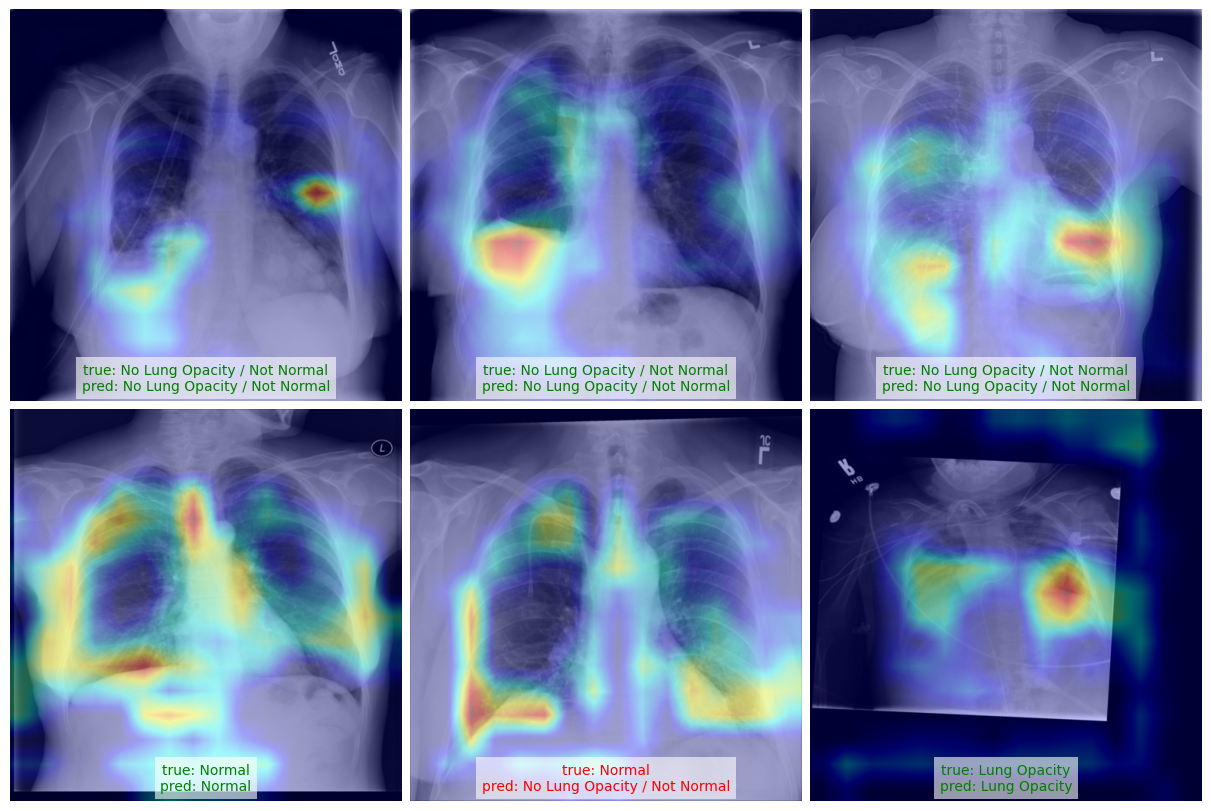

In [17]:
gradcam_dir = REPORTS_FIG / 'gradcam_transfer'
files = sorted(gradcam_dir.glob('*.png'))
id_to_label = {0:'Normal', 1:'Lung Opacity', 2:'No Lung Opacity / Not Normal'}

show_gradcam_png_grid(files, cols=3, id_to_label=id_to_label)

Grad-CAM-визуализация подтверждает:

- модель ResNet50 (Transfer + Optuna) научилась фокусироваться именно на патологически значимых областях снимков, а не на фонах или метках DICOM;

- ошибки стали более интерпретируемыми - чаще связаны с визуальной схожестью патологий или незначительными артефактами;

Таким образом в целом сеть демонстрирует адекватную клиническую интерпретацию признаков, что повышает доверие к модели при использовании в диагностике.

### Сравнение результатов с baseline - ResNet18

In [18]:
df_base = pd.read_csv(REPORTS_DIR / 'baseline_metrics.csv')
df_tr = pd.read_csv(REPORTS_DIR / 'transfer_optuna_metrics.csv')

# Добавим столбец 'model_pretty' для подписей на графиках
df_base['model_pretty'] = 'ResNet18 (Baseline)'
df_tr['model_pretty'] = 'ResNet50 (Transfer + Optuna)'

# Объединяем
df_compare = pd.concat([df_base, df_tr], ignore_index=True)

# Для удобства переупорядочим колонки
cols = ['model_pretty', 'epocs', 'accuracy', 
        'f1_Normal','f1_macro', 'f1_weighted',
        'f1_Lung Opacity', 'f1_No Lung Opacity / Not Normal',
        'recall_Normal','recall_macro', 'recall_weighted',
        'recall_Lung Opacity', 'recall_No Lung Opacity / Not Normal',
        'roc_auc_ovr_macro','roc_auc_ovo_macro', 'pr_auc_macro']
df_compare = df_compare[cols]
display(df_compare)

,model_pretty,epocs,accuracy,f1_Normal,f1_macro,f1_weighted,f1_Lung Opacity,f1_No Lung Opacity / Not Normal,recall_Normal,recall_macro,recall_weighted,recall_Lung Opacity,recall_No Lung Opacity / Not Normal,roc_auc_ovr_macro,roc_auc_ovo_macro,pr_auc_macro
0,ResNet18 (Baseline),5,0.645494,0.748505,0.637943,0.641287,0.566007,0.599319,0.812994,0.647204,0.645494,0.570241,0.558376,0.822589,0.822589,0.685746
1,ResNet50 (Transfer + Optuna),10,0.720817,0.827640,0.714781,0.716067,0.651126,0.665576,0.903390,0.730238,0.720817,0.684954,0.602369,0.882712,0.882712,0.785894


f1 и recall по классам

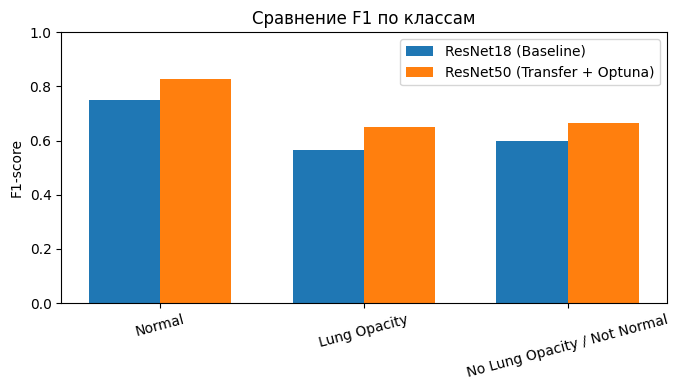

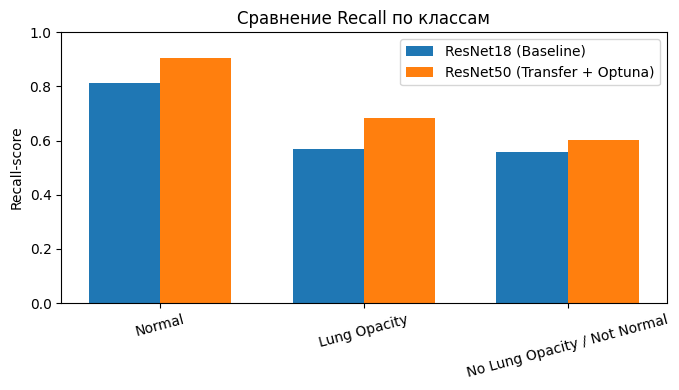

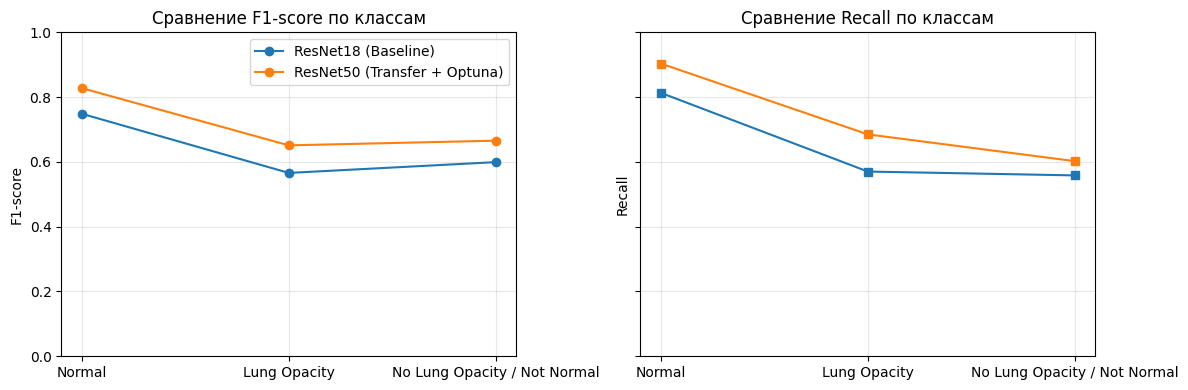

In [19]:
labels = ['Normal', 'Lung Opacity', 'No Lung Opacity / Not Normal']
model_names = ('ResNet18 (Baseline)', 'ResNet50 (Transfer + Optuna)')

plot_metric_bars(df_base, 
                 df_tr, 
                 labels,
                 prefix='f1_', 
                 title='Сравнение F1 по классам', 
                 ylabel='F1-score',
                 model_names=model_names
)

plot_metric_bars(df_base, 
                 df_tr, 
                 labels,
                 prefix='recall_', 
                 title='Сравнение Recall по классам', 
                 ylabel='Recall-score',
                 model_names=model_names
)

plot_metric_classes(df_compare)

По всем представленным графикам наблюдается уверенный прирост метрик качества при переходе от базовой модели ResNet18 к улучшенной ResNet50 (Transfer + Optuna).

Рост F1-score и Recall виден по всем классам, особенно для Normal и Lung Opacity. Это подтверждает, что модель стала лучше различать патологические признаки и реже ошибается в отнесении к "здоровому" классу.

**Для Normal**:

Устойчивый рост F1 (примерно 0.75 до 0.82) и Recall (примерно 0.82 до 0.90);

- Модель демонстрирует высокую уверенность в определении здоровых снимков и стабильное качество без переобучения.

**Для Lung Opacity**:

F1-score вырос с 0.57 до 0.65, Recall с 0.56 до 0.68 - модель стала чувствительнее к пневмониям, хотя этот класс по-прежнему остается наиболее сложным из-за пересечения признаков с классом Not Normal.

**Для No Lung Opacity / Not Normal**:

Метрики улучшились умеренно (F1 с 0.60 до 0.67, Recall с 0.56 до 0.61);

Модель реже путает этот класс с нормой, что говорит о лучшей дифференциации между патологией и здоровым состоянием.

**Общие наблюдения**:

Модель ResNet50 (Transfer + Optuna) показывает устойчивый баланс между Precision и Recall (на графике видна небольшая просадка). Это объясняется тем, что после подбора гиперпараметров и fine-tuning модель стала осторожнее - она реже ошибается в пользу патологий, то есть меньше ложных тревог (false positive). Это автоматически немного снижает recall (чувствительность), но при этом повышает precision (достоверность предсказаний).

Разрыв между линиями на графиках F1-score и Recall подтверждает, что улучшения систематичны, а не случайны.

Улучшение объясняется:

1. применением transfer learning на предобученных весах ImageNet;

2. тщательным подбором гиперпараметров (Optuna, 100 trial’ов);

3. использованием современных техник fine-tuning (заморозка / разморозка блоков, адаптивные LR).

Для дальнейшего улучшения работы сети целесообразно:

- внедрить дообучение с использованием мета-информации (возраст, пол, тип проекции);

Таким образом этап Transfer Learning можно считать успешно завершенным.